# SunWalk MVP – Annotated Notebook

This notebook builds a first end‑to‑end prototype for the **SunWalk** idea:

- define an Area of Interest (AOI) in Berlin‑Mitte  
- download and clean building footprints from OpenStreetMap  
- estimate building heights and compute solar position  
- cast building shadows for a given moment in time  
- rasterize the resulting sun/shade mask  
- export data products (GeoPackage, GeoTIFF, PNG)  
- visualize the result in an interactive Folium map  

Each code cell below is now preceded by a short markdown description explaining what that part of the pipeline does.


### Environment setup: install core geospatial libraries

This cell installs OSMnx, GeoPandas, Shapely, PyProj and Pandas into the Colab environment so we can work with OpenStreetMap data and vector geometries.


In [ ]:
pip install osmnx geopandas shapely pyproj pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 6.0 MB/s eta 0:00:00


### Connect Google Drive and define base paths

This cell mounts Google Drive in Colab and defines the base folder where inputs and outputs will be stored (AOI, buildings, and derived files for the MVP).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Choose where to save results
BASE = "/content/drive/MyDrive/sunwalk_mvp"  # change if you want
import os
os.makedirs(BASE, exist_ok=True)

AOI_PATH = f"{BASE}/aoi_berlin_mitte.geojson"
OUT_GPKG = f"{BASE}/buildings_mitte.gpkg"
OUT_GEOJSON = f"{BASE}/buildings_mitte.geojson"

Mounted at /content/drive


### Define and save the Area of Interest (AOI)

This cell builds a simple GeoJSON polygon around Berlin‑Mitte using hard‑coded coordinates. It creates a `Feature` and writes it to disk so the rest of the pipeline knows which part of the city to process.


In [ ]:
import json

coords = [
    [13.3866650261, 52.5096836095],
    [13.4156699665, 52.5096836095],
    [13.4156699665, 52.5322684336],
    [13.3866650261, 52.5322684336],
    [13.3866650261, 52.5096836095],  # close the ring
]

feature = {
    "type": "Feature",
    "properties": {"name": "Berlin Mitte AOI (MVP)"},
    "geometry": {"type": "Polygon", "coordinates": [coords]},
}
fc = {"type": "FeatureCollection", "features": [feature]}

with open(AOI_PATH, "w", encoding="utf-8") as f:
    json.dump(fc, f, ensure_ascii=False, indent=2)

print("Saved AOI to:", AOI_PATH)

Saved AOI to: /content/drive/MyDrive/sunwalk_mvp/aoi_berlin_mitte.geojson


### Download and preprocess building footprints from OpenStreetMap

This cell reads the AOI polygon, uses OSMnx to download all building geometries inside it, keeps only polygonal footprints, normalizes some key attributes (OSM id, building type, height and number of levels), and saves the cleaned building layer for later use.


In [ ]:
import json
import pandas as pd
import geopandas as gpd
import osmnx as ox
from shapely.geometry import shape

print("OSMnx version:", ox.__version__)  # should say 2.0.6

# (optional) tune Overpass behavior
ox.settings.timeout = 180      # seconds
ox.settings.memory = 4096      # MB on server, some servers ignore this

# Read AOI polygon created earlier
with open(AOI_PATH, "r", encoding="utf-8") as f:
    aoi = json.load(f)
poly = shape(aoi["features"][0]["geometry"])

# ✅ v2.0.6 way to get buildings in polygon
tags = {"building": True}
print("Downloading buildings from OSM…")
gdf = ox.features.features_from_polygon(poly, tags)

# Keep polygons and essential fields
gdf = gdf[gdf.geometry.geom_type.isin(["Polygon", "MultiPolygon"])].copy()
for col in ["osmid", "building", "height", "building:levels"]:
    if col not in gdf.columns:
        gdf[col] = None
gdf = gdf[["osmid", "building", "height", "building:levels", "geometry"]]

# Normalize heights -> height_m
def parse_height(h):
    if h is None:
        return None
    s = str(h).strip().lower().replace("m","")
    try:
        return float(s)
    except:
        return None

h = gdf["height"].apply(parse_height)
lvls = pd.to_numeric(gdf["building:levels"], errors="coerce")
gdf["height_m"] = h.fillna(lvls * 3.0)

# Save outputs
gdf.to_file(OUT_GPKG, driver="GPKG", layer="buildings")
gdf.to_file(OUT_GEOJSON, driver="GeoJSON")

print(f"Saved {len(gdf)} buildings")
print("GeoPackage:", OUT_GPKG)
print("GeoJSON   :", OUT_GEOJSON)

OSMnx version: 2.0.6
Saved 3414 buildings
GeoPackage: /content/drive/MyDrive/sunwalk_mvp/buildings_mitte.gpkg
GeoJSON   : /content/drive/MyDrive/sunwalk_mvp/buildings_mitte.geojson


### Install additional libraries for solar and raster processing

This cell installs extra packages (GeoPandas stack, PyProj, Pysolar and others) that are needed for solar position calculations and later data handling.


In [ ]:
!pip -q install geopandas shapely pyproj pandas rtree pyogrio pysolar

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.6/507.6 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 kB 2.0 MB/s eta 0:00:00


### Re‑establish file paths using `pathlib`

This cell redefines the base directory and important file paths (AOI, building layer, metadata, raster outputs) using `Path` objects, and makes sure the output folder exists. It is a more robust version of the earlier path setup.


In [ ]:
from pathlib import Path
BASE = "/content/drive/MyDrive/sunwalk_mvp"  # or "/content" if not using Drive
AOI_PATH = f"{BASE}/aoi_berlin_mitte.geojson"
BUILDINGS_GPKG = f"{BASE}/buildings_mitte.gpkg"   # from Step 1
SHADOWS_GPKG = f"{BASE}/shadows_mitte.gpkg"       # output file
SHADOWS_GEOJSON = f"{BASE}/shadows_mitte.geojson" # optional export

# CRS: local metric (Berlin) for geometry math, and Web Mercator for quick plotting
CRS_METRIC = "EPSG:25833"   # ETRS89 / UTM zone 33N — good for Berlin
CRS_WEB    = "EPSG:3857"    # Web Mercator

### Load AOI and building layers

This cell reads the AOI geometry and the preprocessed building footprints into GeoPandas GeoDataFrames. It also sets common coordinate reference systems that will be used for geometric operations.


In [ ]:
import geopandas as gpd
import json
from shapely.geometry import shape

# AOI (lat/lon)
aoi = json.load(open(AOI_PATH, "r", encoding="utf-8"))
aoi_poly = shape(aoi["features"][0]["geometry"])
gdf_aoi = gpd.GeoDataFrame(geometry=[aoi_poly], crs="EPSG:4326")

# Buildings: authoritative layer from Step 1
gdf_b = gpd.read_file(BUILDINGS_GPKG, layer="buildings")
print("Buildings:", len(gdf_b), list(gdf_b.columns))

# Reproject both to metric CRS for shadow math
gdf_bm = gdf_b.to_crs(CRS_METRIC)
gdf_aoim = gdf_aoi.to_crs(CRS_METRIC)

Buildings: 3414 ['element', 'id', 'osmid', 'building', 'height', 'building:levels', 'height_m', 'geometry']


### Compute solar position for the current time

This cell uses Pysolar to compute solar altitude and azimuth at the AOI centroid for the current (Berlin) time. The result is a 3D sun direction vector that will drive the shadow‑casting logic.


In [ ]:
from datetime import datetime
from zoneinfo import ZoneInfo
from pysolar.solar import get_altitude, get_azimuth

# Pick a time (local Berlin). Change this to test different moments.
t_local = datetime.now(ZoneInfo("Europe/Berlin"))

# Use AOI centroid for solar calc (good enough for MVP)
cent = gdf_aoi.to_crs("EPSG:4326").geometry.iloc[0].centroid
lat, lon = cent.y, cent.x

# Pysolar expects timezone-aware UTC for best results
t_utc = t_local.astimezone(ZoneInfo("UTC"))

alt_deg = float(get_altitude(lat, lon, t_utc))   # elevation above horizon
azi_deg = float(get_azimuth(lat, lon, t_utc))    # degrees clockwise from North

print("Time (local):", t_local)
print("UTC:", t_utc)
print(f"Sun altitude: {alt_deg:.2f}°   Sun azimuth: {azi_deg:.2f}°")

# Guardrails
if alt_deg <= 0:
    print("⚠️ Sun is below horizon. Everything will be in shade right now.")

Time (local): 2025-11-10 10:35:55.231311+01:00
UTC: 2025-11-10 09:35:55.231311+00:00
Sun altitude: 18.42°   Sun azimuth: 161.29°


### Derive building heights and construct shadow geometry

This cell estimates building heights from explicit `height` values or `building:levels` attributes, builds simplified building volumes, and then casts a shadow polygon in the sun direction. The result is stored as a `gdf_shadow` GeoDataFrame.


In [ ]:
import numpy as np
from shapely import affinity
from shapely.ops import unary_union

def shadow_length_m(height_m: float, alt_deg: float, cap_m: float = 200.0):
    """Length = h / tan(alt); cap very long shadows near low sun."""
    if height_m is None or np.isnan(height_m) or alt_deg <= 0:
        return 0.0
    alt_rad = np.deg2rad(alt_deg)
    L = height_m / np.tan(alt_rad)
    return float(min(max(L, 0.0), cap_m))

def shadow_translate(poly, length_m: float, azimuth_deg: float):
    """
    Translate geometry along the 'shadow direction':
    Pysolar azimuth is degrees clockwise from North.
    Shadow points away from sun: azimuth + 180.
    x is East, y is North in projected CRS.
    """
    theta = np.deg2rad(azimuth_deg + 180.0)
    dx = length_m * np.sin(theta)  # Easting
    dy = length_m * np.cos(theta)  # Northing
    return affinity.translate(poly, xoff=dx, yoff=dy)

def building_shadow(poly, height_m, alt_deg, azimuth_deg):
    L = shadow_length_m(height_m, alt_deg)
    if L <= 0:
        return None
    translated = shadow_translate(poly, L, azimuth_deg)
    # MVP shape: convex hull of original and translated footprint
    return unary_union([poly, translated]).convex_hull

# Compute shadows
if alt_deg > 0:
    # Keep only valid building polys
    gdf_polys = gdf_bm[gdf_bm.geometry.notnull()].copy()
    gdf_polys = gdf_polys[gdf_polys.geometry.geom_type.isin(["Polygon","MultiPolygon"])]

    shadows = []
    for geom, h in zip(gdf_polys.geometry, gdf_polys.get("height_m", [np.nan]*len(gdf_polys))):
        try:
            sh = building_shadow(geom, float(h) if h is not None else np.nan, alt_deg, azi_deg)
            if sh is not None and not sh.is_empty:
                shadows.append(sh)
        except Exception:
            # skip any weird geometries
            pass

    if len(shadows):
        shadow_union = unary_union(shadows)
        gdf_shadow = gpd.GeoDataFrame(geometry=[shadow_union], crs=CRS_METRIC)
    else:
        gdf_shadow = gpd.GeoDataFrame(geometry=[], crs=CRS_METRIC)
else:
    # Sun below horizon -> everything shaded: use AOI as shade (optional)
    gdf_shadow = gdf_aoim.copy()

print("Done. Shadow geometry count:", len(gdf_shadow))

Done. Shadow geometry count: 1


### Save shadow layer and make a quick vector plot

This cell writes the shadow polygons to a GeoPackage and GeoJSON file (so they can be reused outside the notebook) and produces a quick diagnostic plot in Web Mercator showing AOI, buildings, and the current shadow geometry.


Saved: /content/drive/MyDrive/sunwalk_mvp/shadows_mitte.gpkg and /content/drive/MyDrive/sunwalk_mvp/shadows_mitte.geojson


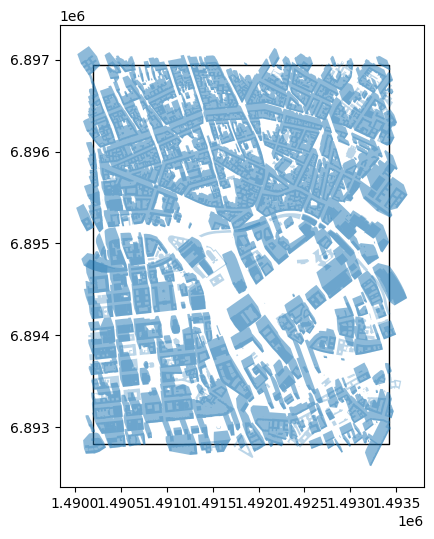

In [ ]:
# Save to GeoPackage + optional GeoJSON
if len(gdf_shadow):
    gdf_shadow.to_file(SHADOWS_GPKG, driver="GPKG", layer="shadow_now")
    gdf_shadow.to_crs("EPSG:4326").to_file(SHADOWS_GEOJSON, driver="GeoJSON")
    print("Saved:", SHADOWS_GPKG, "and", SHADOWS_GEOJSON)

# Quick plot in Web Mercator
ax = gdf_aoim.to_crs(CRS_WEB).plot(edgecolor="black", facecolor="none", figsize=(6,6))
gdf_bm.to_crs(CRS_WEB).plot(ax=ax, alpha=0.3)
if len(gdf_shadow):
    gdf_shadow.to_crs(CRS_WEB).plot(ax=ax, alpha=0.5)

### Install libraries for rasterization and web mapping

This cell installs Rasterio (for raster grids) and Folium (for interactive web maps) used in the next steps.


In [ ]:
!pip -q install rasterio folium pyogrio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 19.6 MB/s eta 0:00:00


### Rasterize the shadow geometry into a sun/shade mask

This cell builds a regular raster grid over the AOI, uses Rasterio to burn the `gdf_shadow` geometry into a binary mask (shadow vs. not shadow), and writes the result as a GeoTIFF file. Resolution and spatial bounds are derived from the AOI extent.


In [ ]:
import math
import numpy as np
import geopandas as gpd
import rasterio
from rasterio.features import rasterize
from rasterio.transform import from_origin

# Inputs from earlier steps
CRS_METRIC = "EPSG:25833"
SHADOWS_GPKG = SHADOWS_GPKG  # from your previous cell
AOI_PATH = AOI_PATH          # same as before

# Load AOI + shadows in metric CRS
gdf_shadow = gpd.read_file(SHADOWS_GPKG, layer="shadow_now").to_crs(CRS_METRIC)
gdf_aoi = gpd.read_file(AOI_PATH).to_crs(CRS_METRIC)

# If no shadow (e.g., sun below horizon), fill AOI with shade=1
geoms = []
if len(gdf_shadow) and not gdf_shadow.geometry.iloc[0].is_empty:
    geoms = [(gdf_shadow.geometry.iloc[0], 1)]
else:
    geoms = [(gdf_aoi.geometry.iloc[0], 1)]

# Resolution in meters (change to 1.0/5.0 to trade accuracy vs size)
res_m = 2.0

# Compute raster grid over AOI bounds
minx, miny, maxx, maxy = gdf_aoi.total_bounds
width  = int(math.ceil((maxx - minx) / res_m))
height = int(math.ceil((maxy - miny) / res_m))

transform = from_origin(minx, maxy, res_m, res_m)

# Burn shade=1, background=0 (sun)
mask = rasterize(
    geoms,  # Pass geometries as positional argument
    out_shape=(height, width),
    transform=transform,
    fill=0,
    dtype="uint8",
)

# Write GeoTIFF (in EPSG:25833)
SUNSHADE_TIF = f"{BASE}/sunshade_mask_2m.tif"
with rasterio.open(
    SUNSHADE_TIF,
    "w",
    driver="GTiff",
    height=height,
    width=width,
    count=1,
    dtype="uint8",
    crs=CRS_METRIC,
    transform=transform,
) as dst:
    dst.write(mask, 1)

print("Saved raster mask:", SUNSHADE_TIF, "| shape:", mask.shape)
print("Legend: 0=sun, 1=shade")

Saved raster mask: /content/drive/MyDrive/sunwalk_mvp/sunshade_mask_2m.tif | shape: (1278, 1012)
Legend: 0=sun, 1=shade


### Visual check of the generated raster mask

This cell uses Matplotlib to open and plot the shadow mask raster, helping to verify that the rasterization worked as expected.


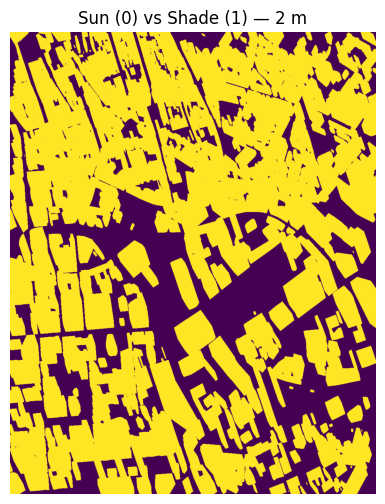

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.imshow(mask, origin="upper")
plt.title("Sun (0) vs Shade (1) — 2 m")
plt.axis("off")
plt.show()

### First interactive Folium map with vector shadows

This cell creates an interactive Folium map centered on the AOI, draws the AOI and buildings as vector layers, and optionally overlays the current shadow polygons. It is an early, vector‑based visualization before using raster tiles.


In [ ]:
import folium
import json
from shapely.geometry import shape
import geopandas as gpd

# Center map on AOI centroid (WGS84)
aoi_wgs = gpd.read_file(AOI_PATH).to_crs(4326)
cent = aoi_wgs.geometry.iloc[0].centroid
m = folium.Map(location=[cent.y, cent.x], zoom_start=15, tiles="CartoDB Positron")

# Add AOI outline
folium.GeoJson(
    aoi_wgs,
    name="AOI",
    style_function=lambda x: {"color":"#111", "weight":2, "fill":False},
).add_to(m)

# Add shadow polygon (if present), converted to WGS84
if len(gdf_shadow) and not gdf_shadow.geometry.iloc[0].is_empty:
    folium.GeoJson(
        gdf_shadow.to_crs(4326),
        name="Shadow now",
        style_function=lambda x: {"color":"#222", "weight":1, "fillColor":"#000000", "fillOpacity":0.35},
    ).add_to(m)
else:
    folium.Marker([cent.y, cent.x], tooltip="No shadow polygon (sun below horizon?)").add_to(m)

folium.LayerControl().add_to(m)
m

### Consolidated imports and helpers for the function‑based API

This cell restates the key imports and utility pieces that are needed when wrapping the previous prototype steps into reusable Python functions (for example, building height estimation and coordinate handling).


In [ ]:
# --- Imports you already have, restated for safety ---
import math, json, numpy as np, pandas as pd
import geopandas as gpd
from shapely.geometry import shape
from shapely import affinity
from shapely.ops import unary_union
from datetime import datetime, timedelta
from zoneinfo import ZoneInfo
from pysolar.solar import get_altitude, get_azimuth
import rasterio
from rasterio.features import rasterize
from rasterio.transform import from_origin

# --- Config you defined earlier (adjust if your paths differ) ---
BASE = "/content/drive/MyDrive/sunwalk_mvp"   # or "/content"
AOI_PATH = f"{BASE}/aoi_berlin_mitte.geojson"
BUILDINGS_GPKG = f"{BASE}/buildings_mitte.gpkg"  # from Step 1
CRS_METRIC = "EPSG:25833"   # ETRS89 / UTM 33N
CRS_WGS = "EPSG:4326"

# --- Load AOI + buildings once, keep in memory (metric CRS for math) ---
aoi_fc = json.load(open(AOI_PATH, "r", encoding="utf-8"))
aoi_wgs_poly = shape(aoi_fc["features"][0]["geometry"])
gdf_aoi_wgs = gpd.GeoDataFrame(geometry=[aoi_wgs_poly], crs=CRS_WGS)

gdf_b = gpd.read_file(BUILDINGS_GPKG, layer="buildings")
# Fall back if height_m missing
if "height_m" not in gdf_b.columns:
    def _parse_height(h):
        if h is None: return None
        s = str(h).strip().lower().replace("m","")
        try: return float(s)
        except: return None
    h = gdf_b["height"].apply(_parse_height) if "height" in gdf_b else pd.Series([None]*len(gdf_b))
    lvls = pd.to_numeric(gdf_b["building:levels"], errors="coerce") if "building:levels" in gdf_b else pd.Series([None]*len(gdf_b))
    gdf_b["height_m"] = h.fillna(lvls * 3.0)

# Keep only polygonal buildings; project to metric CRS
gdf_bm = gdf_b[gdf_b.geometry.geom_type.isin(["Polygon","MultiPolygon"])].copy().to_crs(CRS_METRIC)
gdf_aoim = gdf_aoi_wgs.to_crs(CRS_METRIC)

# Optional: light simplify for speed (tweak tolerance if needed)
gdf_bm["geometry"] = gdf_bm.geometry.simplify(0.2, preserve_topology=True)

# --- Solar helpers ---
def get_sunpos(lat: float, lon: float, dt_local: datetime):
    """Return (alt_deg, azi_deg) for a local Europe/Berlin datetime."""
    dt_utc = dt_local.astimezone(ZoneInfo("UTC"))
    alt = float(get_altitude(lat, lon, dt_utc))
    azi = float(get_azimuth(lat, lon, dt_utc))
    return alt, azi

# --- Shadow helpers (fast MVP) ---
def shadow_length_m(height_m: float, alt_deg: float, cap_m: float = 200.0):
    if height_m is None or np.isnan(height_m) or alt_deg <= 0:
        return 0.0
    alt_rad = math.radians(alt_deg)
    if alt_rad <= 0: return 0.0
    L = height_m / math.tan(alt_rad)
    return float(min(max(L, 0.0), cap_m))

def translate_along_azimuth(geom, length_m: float, azimuth_deg: float):
    # Pysolar azimuth: clockwise from North; shadow points at azimuth+180
    theta = math.radians(azimuth_deg + 180.0)
    dx = length_m * math.sin(theta)  # Easting
    dy = length_m * math.cos(theta)  # Northing
    return affinity.translate(geom, xoff=dx, yoff=dy)

def building_shadow(geom, height_m, alt_deg, azimuth_deg):
    L = shadow_length_m(height_m, alt_deg)
    if L <= 0:
        return None
    shifted = translate_along_azimuth(geom, L, azimuth_deg)
    # MVP: convex hull between original and shifted footprint
    return unary_union([geom, shifted]).convex_hull

def compute_shadow_union(dt_local: datetime):
    """Returns a single (possibly empty) unioned shadow polygon in metric CRS."""
    # solar at AOI centroid (sufficient for MVP)
    cent = gdf_aoi_wgs.geometry.iloc[0].centroid
    lat, lon = cent.y, cent.x
    alt_deg, azi_deg = get_sunpos(lat, lon, dt_local)

    if alt_deg <= 0:
        # sun below horizon → treat AOI as shade (or return empty if you prefer)
        return gdf_aoim.geometry.iloc[0]

    shadows = []
    heights = gdf_bm.get("height_m").to_numpy()
    for geom, h in zip(gdf_bm.geometry.to_numpy(), heights):
        try:
            sh = building_shadow(geom, float(h) if h is not None else np.nan, alt_deg, azi_deg)
            if sh and not sh.is_empty:
                shadows.append(sh)
        except Exception:
            pass

    if not shadows:
        return gdf_aoim.geometry.iloc[0]  # fallback

    return unary_union(shadows)

# --- Rasterizer ---
def rasterize_shadow_polygon(shadow_geom, res_m=2.0, out_tif=None):
    """Rasterize a single polygon to 1=shade, 0=sun in metric CRS."""
    minx, miny, maxx, maxy = gdf_aoim.total_bounds
    width  = int(math.ceil((maxx - minx) / res_m))
    height = int(math.ceil((maxy - miny) / res_m))
    transform = from_origin(minx, maxy, res_m, res_m)

    if shadow_geom is None or shadow_geom.is_empty:
        geoms = []  # all sun
    else:
        geoms = [(shadow_geom, 1)]

    mask = rasterize(
        geoms,  # Pass geometries as positional argument
        out_shape=(height, width),
        transform=transform,
        fill=0,
        dtype="uint8"
    )

    if out_tif:
        with rasterio.open(
            out_tif, "w", driver="GTiff",
            height=height, width=width, count=1, dtype="uint8",
            crs=CRS_METRIC, transform=transform
        ) as dst:
            dst.write(mask, 1)

    return mask, transform

### Function `build_sunshade_mask`: generate one sun/shade raster for a given timestamp

This cell defines a high‑level function that, for a given local timestamp string, recomputes solar position, constructs building shadows, rasterizes them into a mask at the chosen resolution, and optionally saves the outputs (GeoPackage, GeoTIFF, PNG, metadata).


In [ ]:
def build_sunshade_mask(timestamp_local_str: str, res_m=2.0, save=True):
    """
    timestamp_local_str: e.g. '2025-11-10 13:30'
    Returns: (mask_array, transform, alt_deg, azi_deg, out_path_or_None)
    """
    # parse local time in Europe/Berlin
    dt_local = datetime.fromisoformat(timestamp_local_str)
    if dt_local.tzinfo is None:
        dt_local = dt_local.replace(tzinfo=ZoneInfo("Europe/Berlin"))

    # recompute solar + shadow union
    cent = gdf_aoi_wgs.geometry.iloc[0].centroid
    lat, lon = cent.y, cent.x
    alt_deg, azi_deg = get_sunpos(lat, lon, dt_local)

    shadow_union = compute_shadow_union(dt_local)

    # output path
    out_path = None
    if save:
        safe_ts = dt_local.isoformat().replace(":","").replace("+","_").replace("Z","")
        out_path = f"{BASE}/sunshade_{safe_ts}_{int(res_m)}m.tif"

    mask, transform = rasterize_shadow_polygon(shadow_union, res_m=res_m, out_tif=out_path)

    print(f"Time (local): {dt_local}  | alt={alt_deg:.2f}°  azi={azi_deg:.2f}°")
    if out_path:
        print("Saved:", out_path)
    return mask, transform, alt_deg, azi_deg, out_path

### Function `generate_masks_over_range`: batch processing over many times

This cell defines a helper function that loops over a range of times during a day (or multiple days), calling `build_sunshade_mask` repeatedly to precompute a series of sun/shade masks that can later be animated or queried.


In [ ]:
def generate_masks_over_range(
    start_local: str,
    end_local: str,
    step_minutes: int = 10,
    res_m: float = 2.0,
    save=True,
):
    """
    Build a sequence of masks between start and end (inclusive), every step_minutes.
    Times are interpreted in Europe/Berlin if tz-naive.
    Returns: list of dicts with { 'dt': dt_local, 'alt':..., 'azi':..., 'path':..., 'mask':..., 'transform':... }
    """
    tz = ZoneInfo("Europe/Berlin")
    t0 = datetime.fromisoformat(start_local)
    t1 = datetime.fromisoformat(end_local)
    if t0.tzinfo is None: t0 = t0.replace(tzinfo=tz)
    if t1.tzinfo is None: t1 = t1.replace(tzinfo=tz)

    out = []
    t = t0
    while t <= t1:
        mask, transform, alt, azi, path = build_sunshade_mask(t.isoformat(), res_m=res_m, save=save)
        out.append({"dt": t, "alt": alt, "azi": azi, "path": path, "mask": mask, "transform": transform})
        t += timedelta(minutes=step_minutes)
    return out

### Time zone utilities

This cell imports `ZoneInfo` and configures the Berlin time zone handling that is used when converting between local time strings and timezone‑aware datetimes.


In [ ]:
from zoneinfo import ZoneInfo
ts = datetime.now(ZoneInfo("Europe/Berlin")).replace(second=0, microsecond=0).isoformat()
mask, transform, alt, azi, path = build_sunshade_mask(ts, res_m=2.0, save=True)

Time (local): 2025-11-10 10:45:00+01:00  | alt=18.84°  azi=163.53°
Saved: /content/drive/MyDrive/sunwalk_mvp/sunshade_2025-11-10T104500_0100_2m.tif


### Example: generate masks for a specific day

This cell sets a sample date (for example 2025‑11‑10), defines a time range and step, and calls `generate_masks_over_range` to actually compute and save a sequence of sun/shade masks for that period.


In [ ]:
day = "2025-11-10"  # change date freely
out_seq = generate_masks_over_range(
    start_local=f"{day} 10:00",
    end_local=f"{day} 14:00",
    step_minutes=10,
    res_m=2.0,
    save=True,
)
print(f"Generated {len(out_seq)} masks")

Time (local): 2025-11-10 10:00:00+01:00  | alt=16.30°  azi=152.59°
Saved: /content/drive/MyDrive/sunwalk_mvp/sunshade_2025-11-10T100000_0100_2m.tif
Time (local): 2025-11-10 10:10:00+01:00  | alt=16.96°  azi=154.98°
Saved: /content/drive/MyDrive/sunwalk_mvp/sunshade_2025-11-10T101000_0100_2m.tif
Time (local): 2025-11-10 10:20:00+01:00  | alt=17.58°  azi=157.39°
Saved: /content/drive/MyDrive/sunwalk_mvp/sunshade_2025-11-10T102000_0100_2m.tif
Time (local): 2025-11-10 10:30:00+01:00  | alt=18.13°  azi=159.83°
Saved: /content/drive/MyDrive/sunwalk_mvp/sunshade_2025-11-10T103000_0100_2m.tif
Time (local): 2025-11-10 10:40:00+01:00  | alt=18.62°  azi=162.29°
Saved: /content/drive/MyDrive/sunwalk_mvp/sunshade_2025-11-10T104000_0100_2m.tif
Time (local): 2025-11-10 10:50:00+01:00  | alt=19.04°  azi=164.77°
Saved: /content/drive/MyDrive/sunwalk_mvp/sunshade_2025-11-10T105000_0100_2m.tif
Time (local): 2025-11-10 11:00:00+01:00  | alt=19.41°  azi=167.27°
Saved: /content/drive/MyDrive/sunwalk_mvp/sun

### Optional plotting of a mask sequence

This cell uses Matplotlib to inspect or compare one or several of the generated raster masks (for debugging, quality checks or presentation).


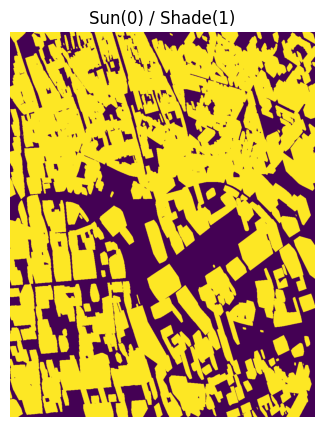

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.imshow(mask, origin="upper")
plt.title("Sun(0) / Shade(1)")
plt.axis("off")
plt.show()

### Install Pillow and post‑process rasters to PNG

This cell installs the Pillow image library and uses it, together with Rasterio, to convert the GeoTIFF shadow masks into RGBA PNG images that are easier to overlay on web maps with transparency.


In [ ]:
!pip -q install pillow

import json, numpy as np, rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from PIL import Image

# INPUT: pick the latest or a specific mask you generated earlier
# If you used build_sunshade_mask(..., save=True), it printed a path like ".../sunshade_YYYYMMDDTHHMM..."
SUNSHADE_TIF = SUNSHADE_TIF if 'SUNSHADE_TIF' in globals() else f"{BASE}/sunshade_mask_2m.tif"

PNG_OUT   = f"{BASE}/sunshade_overlay.png"
META_JSON = f"{BASE}/sunshade_overlay_bounds.json"

dst_crs = "EPSG:4326"  # WGS84 for web maps

with rasterio.open(SUNSHADE_TIF) as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds
    )
    kwargs = src.meta.copy()
    kwargs.update({
        "crs": dst_crs,
        "transform": transform,
        "width": width,
        "height": height,
        "dtype": "uint8",
        "count": 1
    })

    # Reproject mask band -> WGS84
    dst = np.zeros((height, width), dtype="uint8")
    reproject(
        source=rasterio.band(src, 1),
        destination=dst,
        src_transform=src.transform,
        src_crs=src.crs,
        dst_transform=transform,
        dst_crs=dst_crs,
        resampling=Resampling.nearest,
    )

# Build an RGBA overlay: sun(0)=transparent, shade(1)=semi-opaque black
alpha_val = 120  # 0..255 (tweak opacity)
R = np.zeros_like(dst, dtype=np.uint8)
G = np.zeros_like(dst, dtype=np.uint8)
B = np.zeros_like(dst, dtype=np.uint8)
A = (dst * alpha_val).astype(np.uint8)  # 0 where sun, alpha_val where shade

rgba = np.dstack([R, G, B, A])

# Save PNG
Image.fromarray(rgba, mode="RGBA").save(PNG_OUT, compress_level=6)

# Compute geographic bounds (lat/lon) from transform
# Upper-left of pixel (0,0), lower-right of pixel (width, height)
minx, miny = transform * (0, height)
maxx, maxy = transform * (width, 0)

# Leaflet/MapLibre need [South, West, North, East] and the 4 corner coords
bounds = {
    "bbox_south_west_north_east": [miny, minx, maxy, maxx],
    "image_corners": {
        "top_left":     [maxy, minx],  # [lat, lon]
        "top_right":    [maxy, maxx],
        "bottom_right": [miny, maxx],
        "bottom_left":  [miny, minx],
    },
    "png": PNG_OUT
}

with open(META_JSON, "w", encoding="utf-8") as f:
    json.dump(bounds, f, indent=2)

print("PNG overlay:", PNG_OUT)
print("Bounds JSON:", META_JSON)
print("Bounds (S,W,N,E):", bounds["bbox_south_west_north_east"])

PNG overlay: /content/drive/MyDrive/sunwalk_mvp/sunshade_overlay.png
Bounds JSON: /content/drive/MyDrive/sunwalk_mvp/sunshade_overlay_bounds.json
Bounds (S,W,N,E): [52.50928714236349, 13.38583766608451, 52.532660211586354, 13.416495847792422]


/tmp/ipython-input-4151240658.py:52: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba, mode="RGBA").save(PNG_OUT, compress_level=6)


### Final interactive Folium map with raster overlay

This last cell reads the AOI metadata and the exported PNG mask, builds a Folium map centered on the AOI, and overlays the sun/shade raster using `ImageOverlay`, giving a web‑map preview of where there is sun or shade at the selected time.



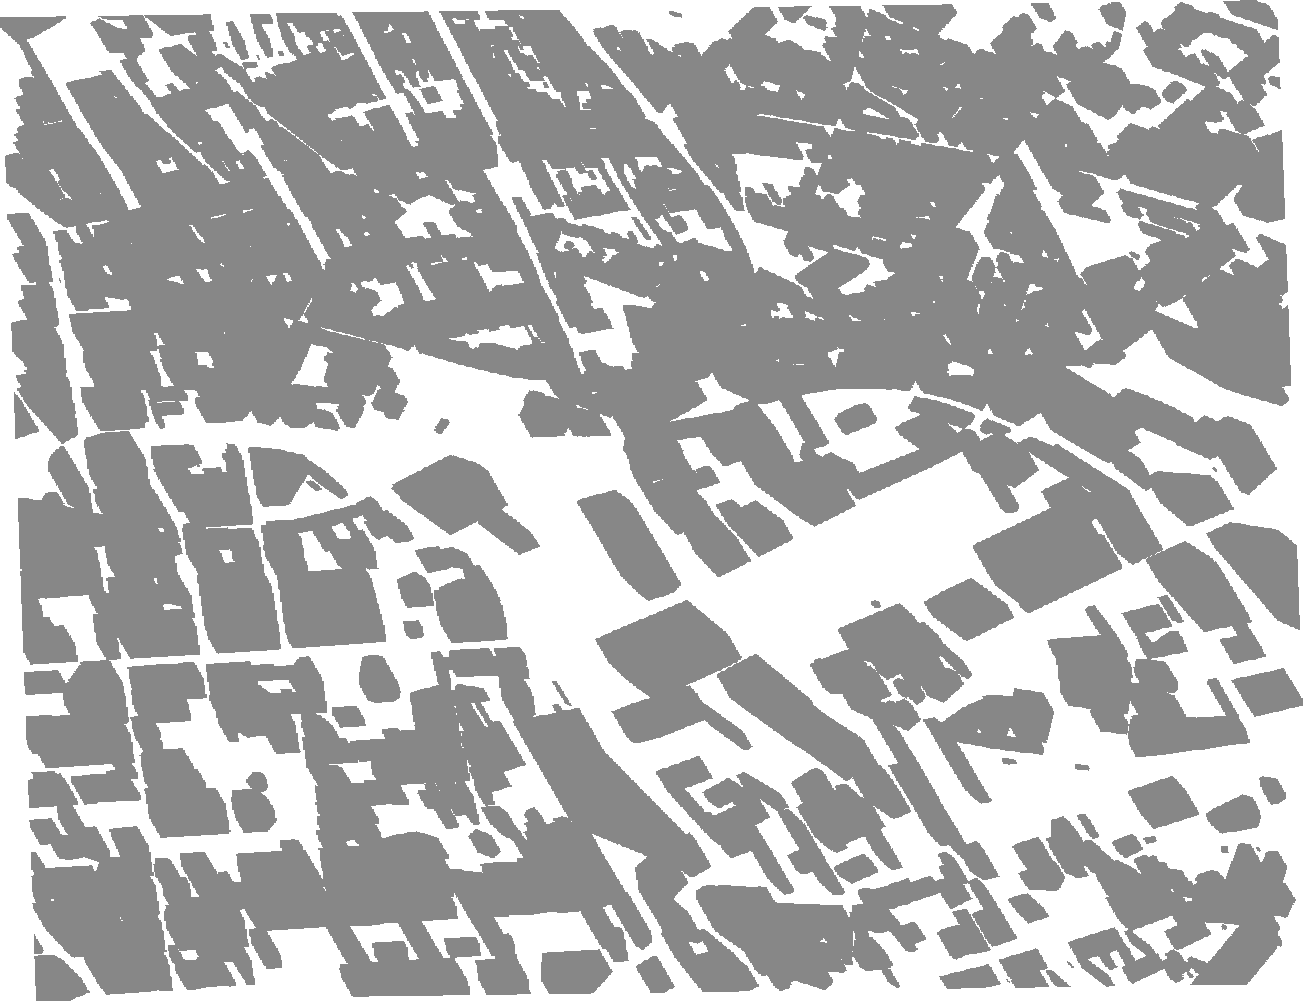

In [ ]:
import json, folium

with open(META_JSON, "r", encoding="utf-8") as f:
    meta = json.load(f)

south, west, north, east = meta["bbox_south_west_north_east"]

# Map centered on AOI
center_lat = (south + north) / 2
center_lon = (west + east) / 2
m = folium.Map(location=[center_lat, center_lon], zoom_start=15, tiles="CartoDB Positron")

# Overlay: use ImageOverlay with bounds [[south, west], [north, east]]
folium.raster_layers.ImageOverlay(
    name="Sunshade overlay",
    image=PNG_OUT,
    bounds=[[south, west], [north, east]],
    opacity=1.0,      # overall opacity; per-pixel alpha is preserved
    interactive=False,
    cross_origin=False
).add_to(m)

folium.LayerControl().add_to(m)
m